# CS985 Coursework (Classification)
**Group 7** - Student Numbers: 202482083, 202459117, 202482007, 202481426, 202477052

In [2]:
# Importing necessary libraries
# Dataframe and mathematics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import f_oneway
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
# Data transformation
import string
from gensim.parsing.preprocessing import remove_stopwords
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, power_transform
# Model training
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import VotingClassifier, StackingClassifier
# Metrics
from sklearn.metrics import accuracy_score

# Import classification dataset
df = pd.read_csv("CS98XClassificationTrain.csv")

# Exploratory Data Analysis (EDA)

In [4]:
# Features with missing values
df.isna().sum()[df.isna().sum() > 0]

top genre    15
dtype: int64

We note that the dataset is very small, with only 453 instances. A small dataset may not capture the full variability of the population, while also being more susceptible to noise and outliers. We further note 15 instances of missing genres. Considering that the dataset is already so small, we were hesitant to drop these instances and were in favour of imputation instead. EDA was then performed to explore the distribution of genres in the dataset.

Number of unique genres: 86


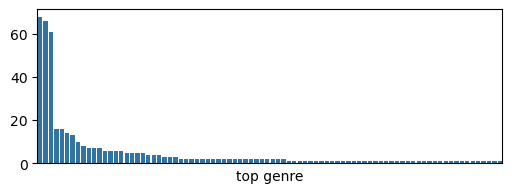

top genre
adult standards       68
album rock            66
dance pop             61
brill building pop    16
glam rock             16
Name: count, dtype: int64


In [6]:
# Number of unique genres
print('Number of unique genres:', df['top genre'].nunique())
# Distribution of songs in each genre
genre_counts = df['top genre'].value_counts()
plt.figure(figsize=(6,2))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.xticks([])
plt.show()
print(genre_counts.head())

We noted a very distinct class imbalance between the top 3 genres and the remaining genres in the dataset. Given the dominance of these 3 genres, mode imputation appears to be a viable method of filling the missing genres. There are 86 total genres in the training dataset, with 40 of them having only 1 song each. This would be extremely challenging for the classification model to learn meaningful relationships for these rare genres, unless features with strong predictive powers for each class exist.

Number of unique artists: 345


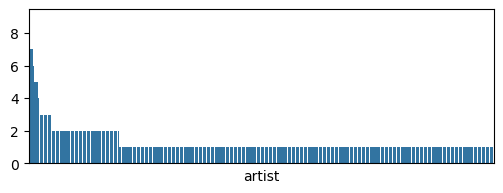

In [8]:
# Number of unique artists
print('Number of unique artists:', df['artist'].nunique())
# Distribution of songs by each artist
artist_counts = df['artist'].value_counts()
plt.figure(figsize=(6,2))
sns.barplot(x=artist_counts.index, y=artist_counts.values)
plt.xticks([])
plt.show()

In [9]:
# Group all artists with only 1 song under 'other_artists'
other_artists = artist_counts[artist_counts == 1].index.tolist()
print(f'Number of artists with only 1 song each: {len(other_artists)}')

Number of artists with only 1 song each: 278


Similar to the 'top genre' feature, the distribution of artists is also somewhat imbalanced, with some artists having multiple songs in the dataset, while most (278 artists) having only 1 song at maximum. We hypothesised that music artists tend to produce songs of their favourite style. To test this hypothesis, we decided to plot a heatmap to visualise the correlations between 'top genre' and 'artist'. To reduce the complexity of the heatmap, we will group the artists and genres with only a single instance under 'other'.

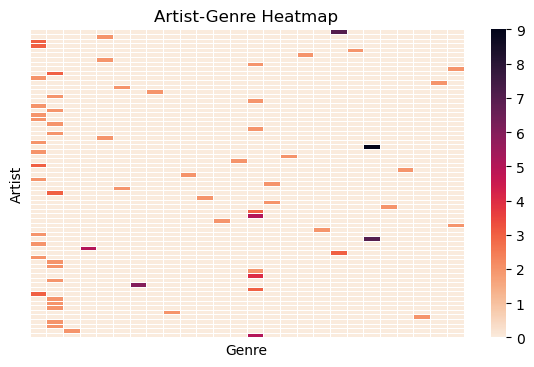

Max number of genres produced by any artist: 1


In [11]:
# Group all genres with only 1 song under 'other_genres'
other_genres = genre_counts[genre_counts == 1].index.tolist()
df_art_gen = pd.DataFrame(df[['artist', 'top genre']], columns=['artist', 'top genre'])
df_art_gen['top genre'] = df_art_gen['top genre'].apply(lambda x: 'missing' if x is np.nan else x)
df_art_gen['top genre'] = df_art_gen['top genre'].apply(lambda x: 'other' if x in other_genres else x)
df_art_gen['artist'] = df_art_gen['artist'].apply(lambda x: 'other' if x in other_artists else x)
df_art_gen.drop(df_art_gen[df_art_gen['artist'] == 'other'].index, inplace=True)
df_art_gen.drop(df_art_gen[df_art_gen['top genre'] == 'other'].index, inplace=True)
artist_genre_counts = pd.crosstab(df_art_gen['artist'], df_art_gen['top genre'])
plt.figure(figsize=(7, 4))
sns.heatmap(artist_genre_counts, cmap="rocket_r", annot=False, linewidths=0.5)
plt.title("Artist-Genre Heatmap")
plt.xlabel("Genre")
plt.ylabel("Artist")
plt.xticks([])
plt.yticks([])
plt.show()
artist_genre_counts = df.groupby('artist')['top genre'].nunique().reset_index()
print(f'Max number of genres produced by any artist: {max(artist_genre_counts['top genre'])}')

The cells in above heatmap correspond to the number of songs produced by each artist in each genre. A cursory observation seemingly reveals that each artist produces songs in only 1 genre. This is confirmed after we tabulated the number of genres each artist has produced songs in, meaning there is a very strong correlation between each artist and a specific genre, making the artist's name a very strong predictor. One-hot encoding the artist columns may be a viable data transformation, although this could make the dataset extremely sparse.

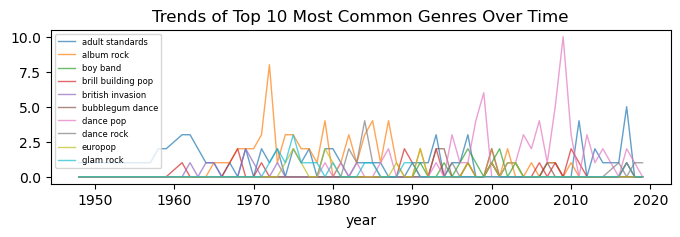

In [13]:
# Time series analysis of genres over the years
top_genres = df['top genre'].value_counts().index[:10]
df_top_gen = df[df['top genre'].isin(top_genres)]
df_top_gen = df_top_gen.groupby(['year', 'top genre']).size().unstack(fill_value=0)
ax = df_top_gen.plot(figsize=(8,2), kind='line', linewidth=1, alpha=0.7, colormap='tab10');
plt.legend(fontsize=6)
plt.title('Trends of Top 10 Most Common Genres Over Time');

The line plot above shows the frequency of genres over time in the dataset. The most common 'adult standards' genre has had a sustained presence in the dataset over time, while 'album rock' and 'dance pop' had surges in instancces in the 1970s and 2000s respectively. This illustrates that the 'year' feature may have some predictive importance.

In [15]:
# Add title length column (by characters)
df['title_chars'] = df['title'].str.len()
# Add title length column (by words)
df['title_words'] = df['title'].apply(lambda x: ''.join([char for char in x if char not in string.punctuation]))
df['title_words'] = df['title_words'].apply(lambda x: ' '.join([x.lower()]))
df['title_words'] = df['title_words'].apply(remove_stopwords)
df['title_words'] = df['title_words'].apply(lambda x: len(x.split()))

In [16]:
df_num = df[['title_chars', 'title_words', 'year', 'bpm', 'nrgy', 'dnce', 'dB', 'live', 'val', 'dur', 'acous', 'spch', 'pop']].copy()
# Tabulate skewness and kurtosis
skewness = df_num[df_num.columns].skew()
kurtosis = df_num[df_num.columns].kurtosis()
variance = df_num[df_num.columns].var()
skew_kurt_df = pd.DataFrame({'Skewness': skewness, 'Kurtosis': kurtosis, 'Variance': variance})
print(skew_kurt_df)

             Skewness   Kurtosis     Variance
title_chars  1.367433   3.349717   142.147727
title_words  1.011517   1.051480     1.954619
year        -0.234780  -1.119421   281.437643
bpm          0.358070   0.059346   636.992655
nrgy        -0.330225  -0.747531   493.074645
dnce        -0.215154  -0.258065   239.768427
dB          -0.685209   0.420188    12.796265
live         2.120281   5.491427   191.277188
val         -0.282285  -0.913984   602.205132
dur          0.808863   1.472015  4066.661402
acous        0.652120  -0.896153   872.021811
spch         3.940009  18.277734    30.808953
pop         -0.650195  -0.362839   181.443132


We analysed the distributions of all the numeric columns, with the additional 'title_chars' and 'title_words' columns. High right-tailed skewness and kurtosis observed for 'title_chars', 'title_words', 'live' and 'spch' features. Applied Yeo-Johnson transformation to reduce them.

In [18]:
# Yeo-Johnson transform skewed columns
df_num = power_transform(df_num, method='yeo-johnson')
# Perform scaling on numerical columns
scaler = MinMaxScaler()
df_num = scaler.fit_transform(df_num)
df_num = pd.DataFrame(df_num, columns=['title_chars', 'title_words', 'year', 'bpm', 'nrgy', 'dnce', 'dB', 'live', 'val', 'dur', 'acous', 'spch', 'pop'])

In [19]:
# Investigate any correlations between numerical features and top genre
num_col = df_num.columns
df_num_genre = pd.concat([df_num, df['top genre']], axis=1)
mode_genre = df['top genre'].mode()[0]
df_num_genre['top genre'] = df_num_genre['top genre'].apply(lambda x: mode_genre if x is np.nan else x)
target = df_num_genre['top genre']
# Perform ANOVA for each numeric column
anova_df = {}
for col in num_col:
    groups = [df_num[col][target == cat] for cat in target.unique()]
    anova_df[col] = f_oneway(*groups).pvalue
anova_df = pd.DataFrame.from_dict(anova_df, orient='index', columns=['ANOVA p-value']).sort_values(by='ANOVA p-value')
print(anova_df)

             ANOVA p-value
dur           2.921296e-24
pop           2.862712e-21
nrgy          5.509877e-18
acous         2.435229e-17
dB            4.864357e-16
year          6.476252e-15
dnce          2.376198e-09
spch          9.450160e-08
title_words   1.351168e-02
val           7.283903e-02
bpm           9.415095e-02
live          1.552768e-01
title_chars   1.963951e-01


ANOVA is used to determine if there are significant differences between the means of different categories by comparing the within-group variances with the between-group variances. The lower the p-value, the more likely that there are statistically-significant differences across groups for a particular feature, and thus the feature may be useful for the model.

# Dataset Transformation Pipeline

The training dataset is reimported and put through a data transformation pipeline, ensuring that the transformations performed on the training dataset will also be performed on the test dataset. The missing genres are first imputed using mode imputation. We opted for this method due to the imbalanced nature of the dataset. A column for the number of words in the title is added. This is because based on our ANOVA analysis, the number of words in the title has a low p-value and thus could be a useful feature for the model.

In [23]:
# Reimport dataset
df_clf = pd.read_csv("CS98XClassificationTrain.csv")
# Impute missing genre with the most common genre in the dataset
df_clf['top genre'] = df_clf['top genre'].apply(lambda x: mode_genre if x is np.nan else x)
# Add title length column (by words)
df_clf['title_words'] = df_clf['title'].apply(lambda x: ''.join([char for char in x if char not in string.punctuation]))
df_clf['title_words'] = df_clf['title_words'].apply(lambda x: ' '.join([x.lower()]))
df_clf['title_words'] = df_clf['title_words'].apply(remove_stopwords)
df_clf['title_words'] = df_clf['title_words'].apply(lambda x: len(x.split()))

rand_state = 69 # Setting random state for train-test split and training

One-hot encoding is applied to the artist feature to separate them into different columns. However, drop_first will not be implemented as we will lose the predictive power of that artist dropped. We had attempted to apply TF-IDF and word2vec embeddings to the 'title' and 'artist' names, followed by a PCA dimensionality reduction to these columns, but the trained models did not perform well with them. Furthermore, it only increased the dimensionality of the dataset, which made it less computationally-efficient.

In [25]:
df_artist = df_clf['artist'].reset_index(drop=True)
df_artist = pd.get_dummies(data=df_artist)
included_artists = df_artist.columns # Save list of artist columns for data transformation on test set

The following features were selected due to having significantly lower ANOVA p-values, indicating their importance and differentiating features. No scaling was applied to this training data since no learning algorithm that employs distance measure was used. PCA will also not be employed as we wish to preserve the sparse nature of the one-hot encoded data. By one-hot encoding the artists, each artist gets its own separate dimension. Linear models are capable of finding the decision boundary in these high-dimensional spaces to separate the categories. As such, linear models will be favoured for this classification problem.

In [27]:
# Extract numeric columns
num_cols = ['dur', 'pop', 'nrgy', 'acous', 'dB', 'year', 'dnce', 'spch', 'title_words', 'val']
df_num = df_clf[num_cols].copy()
# Apply Yeo-Johnson transformation to adjust for skewness and kurtosis
df_num = power_transform(df_num, method='yeo-johnson')
df_num = pd.DataFrame(df_num, columns=num_cols)
X = pd.concat([df_artist, df_num], axis=1)
y = df_clf['top genre']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state = rand_state)

The linear models we have identified are: 1) Logistic Regression - good at probabilitistic predictions, 2) Ridge Classifier - handles multicollinearity well, and 3) Linear Support Vector Classification - hinge loss objective deals with high dimensionality effectively. Thereafter, we will include the above linear models as the base estimators of the following ensemble learning models: 4) Hard Voting Classifier, 5) Soft Voting Classifier, and 6) Stacking Classifier. We have experimented training tree-based models like DecisionTreeClassifier and RandomForest, but none of them came close to the same level of accuracy that the above linear models achieved. This is mainly due to the highly sparse nature of the dataset with the 345 one-hot encoded artist columns, which tree-based models struggle to deal with.

In [29]:
models_clf = {
    'Logistic Classifier': LogisticRegression(random_state=rand_state),
    'Ridge Classifier': RidgeClassifier(random_state=rand_state),
    'Linear SVM': LinearSVC(dual='auto', random_state=rand_state)
}
param_grids_clf = {
    'Logistic Classifier': {'C': [0.01, 0.1, 1, 10], 'solver': ['lbfgs', 'liblinear']},
    'Ridge Classifier': {'alpha': [0.01, 0.1, 1, 10], 'solver': ['auto', 'lsqr']},
    'Linear SVM': {'C': [0.01, 0.1, 1, 10], 'dual': [False]}
}

In [30]:
# Fit the models
grids_clf = {}
for model_name, model in models_clf.items():
    grids_clf[model_name] = GridSearchCV(estimator=model, param_grid=param_grids_clf[model_name], cv=KFold(n_splits=5, shuffle=True, random_state=rand_state), scoring='accuracy', n_jobs=-1, verbose=0)
    grids_clf[model_name].fit(X_train, y_train)
    best_params = grids_clf[model_name].best_params_
    best_score = grids_clf[model_name].best_score_
    print(f'Best parameters for {model_name}: {best_params}')
    print(f'Best accuracy score for {model_name}: {best_score:.5f}')
clf_log = grids_clf['Logistic Classifier']
clf_rid = grids_clf['Ridge Classifier']
clf_svm = grids_clf['Linear SVM']

Best parameters for Logistic Classifier: {'C': 10, 'solver': 'liblinear'}
Best accuracy score for Logistic Classifier: 0.52481
Best parameters for Ridge Classifier: {'alpha': 1, 'solver': 'auto'}
Best accuracy score for Ridge Classifier: 0.55529
Best parameters for Linear SVM: {'C': 1, 'dual': False}
Best accuracy score for Linear SVM: 0.55799


In [31]:
# Ensemble Learning (Hard Voting Classifier)
estimators = [('Logistic Classifier', clf_log), ('Ridge Classifier', clf_rid), ('Linear SVM', clf_svm)]
clf_hvot = VotingClassifier(estimators=estimators, voting='hard')
clf_hvot.fit(X_train, y_train)
y_pred = clf_hvot.predict(X_val)
print(f'Best accuracy score for Ensemble (Hard Voting): {accuracy_score(y_val, y_pred):.5f}')

# Ensemble Learning (Soft Voting Classifier)
estimators = [('Logistic Classifier', clf_log), ('Ridge Classifier', CalibratedClassifierCV(clf_rid)), ('Linear SVM', CalibratedClassifierCV(clf_svm))]
clf_svot = VotingClassifier(estimators=estimators, voting='soft')
clf_svot.fit(X_train, y_train)
y_pred = clf_svot.predict(X_val)
print(f'Best accuracy score for Ensemble (Soft Voting): {accuracy_score(y_val, y_pred):.5f}')

# Ensemble Learning (Stacking Classifier)
estimators = [('Logistic Classifier', clf_log), ('Ridge Classifier', clf_rid), ('Linear SVM', clf_svm)]
clf_stk = StackingClassifier(estimators=estimators, final_estimator=RidgeClassifier(alpha=0.01, solver='lsqr'), cv='prefit')
clf_stk.fit(X_train, y_train)
y_pred = clf_stk.predict(X_val)
print(f'Best accuracy score for Ensemble (Stacking): {accuracy_score(y_val, y_pred):.5f}')

Best accuracy score for Ensemble (Hard Voting): 0.52747
Best accuracy score for Ensemble (Soft Voting): 0.51648
Best accuracy score for Ensemble (Stacking): 0.52747


LinearSVC performed best with an accuracy score of 0.55799, while RidgeClassifier came in close at 0.55529. Despite having the added element of diversity, the ensemble models did not perform as well (Hard Voting and Stacking at 0.52747, Soft Voting at 0.51648) as the standalone LinearSVC and RidgeClassifier models. Moreover, given that our base models (Logistic Regression, Ridge Classifier, and Linear SVC) are all linear classifiers, voting and stacking did not provide a significant advantage as they rely on a diverse set of weak learners to create a strong ensemble model. Furthermore, since our dataset has only 453 samples, adding a meta-model in stacking could increase variance without a clear benefit. Since LinearSVC obtained the highest accuracy among individual classifiers, LinearSVC was chosen as the final model.

In [33]:
# Dictionary to collect the final models
final_models = {'Logistic Classifier': clf_log, 'Ridge Classifier': clf_rid, 'Linear SVM': clf_svm, 'Ensemble (Hard Voting)': clf_hvot, 'Ensemble (Soft Voting)': clf_svot, 'Ensemble (Stacking)': clf_stk}

# Final Submission

In [35]:
df_test = pd.read_csv('CS98XClassificationTest.csv')
# Add title length column (by words)
df_test['title_words'] = df_test['title'].apply(lambda x: ''.join([char for char in x if char not in string.punctuation]))
df_test['title_words'] = df_test['title_words'].apply(lambda x: ' '.join([x.lower()]))
df_test['title_words'] = df_test['title_words'].apply(remove_stopwords)
df_test['title_words'] = df_test['title_words'].apply(lambda x: len(x.split()))
# Onehot encoded artist transformations
df_artist = pd.get_dummies(df_test['artist'])
df_artist = df_artist.reindex(columns=included_artists, fill_value=False)
# Numerical column transformations
df_num = df_test[num_cols].copy()
df_num = power_transform(df_num, method='yeo-johnson')
df_num = pd.DataFrame(df_num, columns=num_cols)
# Merge one-hot encoded artist columns and numeric columns
X_test = pd.concat([df_artist, df_num], axis=1)
# Predictions and output to .csv
y_pred = clf_svm.predict(X_test)
output = pd.DataFrame({'Id': df_test['Id'], 'top genre': y_pred})
output.to_csv('submission.csv', index=False)

# Kaggle Result
Highest score: 0.62500 (model - LinearSVC)

The difference between the training score of 0.55799 and the Kaggle score of 0.62500 could be due to the class imbalance observed in the training set, while the test set might have a large proportion of common genres like 'adult standards'. This would result in the model being able to make more accurate predictions.